In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from IPython.display import clear_output
from datetime import timedelta
from scipy.stats import skewnorm
import inspect, re
import h2o
from h2o.automl import H2OAutoML
import xgboost as xgb
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn import  metrics
import time
import progressbar
import warnings
import math
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV as LogReg
from scipy import signal
               
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from WOE_Houston import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
fy_10 = pd.read_csv('2010_clfpred')
fy_11 = pd.read_csv('2011_clfpred')
fy_12 = pd.read_csv('2012_clfpred')
fy_13 = pd.read_csv('2013_clfpred')
fy_14 = pd.read_csv('2014_clfpred')
fy_15 = pd.read_csv('2015_clfpred')
fy_16 = pd.read_csv('2016_clfpred')

fy_list = [fy_10, fy_11, fy_12, fy_13, fy_14, fy_15, fy_16]

del fy_10
del fy_11
del fy_12
del fy_13
del fy_14
del fy_15
del fy_16
gc.collect()

essentials = ['Unnamed: 0',
 'Fund Id',
 'Business Area',
 'Fund Center Id',
 'GL Account',
 'GL Description',
 'GL Category',
 'GL Category Description',
 'Revenue or Expenditure',
 'Fiscal Year',
 'Fund Name',
 'Fund Type Descr',
 'Business Area Name',
 'Fund Center Name',
 'Commitment Set Description',
 'Original Budget',
 'Current Budget',
 'Actuals',
 '3Y_Past_Actuals',
 '2Y_Past_Actuals',
 '1Y_Past_Actuals',
 '2Y_1Y_Actuals_Mean',
 '3Y_2Y_1Y_Actuals_Mean',
 '3Y_Past_Original_Budget',
 '2Y_Past_Original_Budget',
 '1Y_Past_Original_Budget',
 '2Y_1Y_Original_Budget_Mean',
 '3Y_2Y_1Y_Original_Budget_Mean',
 '3Y_Past_OA_Difference',
 '2Y_Past_OA_Difference',
 '1Y_Past_OA_Difference',
 '2Y_1Y_OA_Difference_Mean',
 '3Y_2Y_1Y_OA_Difference_Mean',
 'OA_Difference',
 'Yearly Crime Index',
 'Yearly Avg High Temp',
 'Yearly Avg Low Temp',
 'Yearly Rain Fall',
 'Astros Playoff Rounds',
 'Astros Yearly Attendance',
 'Rockets Playoff Rounds',
 'Texans Playoff Rounds',
 'Texans Average Attendance',
 'Rockets Total Attendance']

dummies = ['Fund Name_Asset Forfeiture Fund - Justice',
 'Fund Name_Asset Forfeiture Fund - State',
 'Fund Name_Auto Dealers Fund',
 'Fund Name_Building Inspection Fund',
 'Fund Name_C&E-Civic Center Facility Revenue Fund',
 'Fund Name_Cable Television Fund',
 'Fund Name_Child Safety Fund',
 'Fund Name_Digital Houston Special Revenue',
 'Fund Name_Expansion of Recycling Program',
 'Fund Name_Fleet Management Fund',
 'Fund Name_GSD - In-House Renovation Revolving Fund',
 'Fund Name_General Fund',
 'Fund Name_Greater Houston Trans & Emer Center',
 'Fund Name_HAS-Revenue Fund',
 'Fund Name_Health Benefits Fund',
 'Fund Name_Historic Preservation Fund',
 'Fund Name_Houston Emergeny Center',
 'Fund Name_Long-Term Disablility Plan Fund',
 'Fund Name_Municipal Court Technology Fund',
 'Fund Name_PWE-Combined Utility System Gen Pur Fund',
 'Fund Name_PWE-Combined Utility System Oper Fund',
 'Fund Name_PWE-W & S System Operating Fund',
 'Fund Name_Park Special Revenue Fund',
 'Fund Name_Parking Mangement Operating Fund',
 'Fund Name_Police Special Services',
 'Fund Name_Project Cost Recovery',
 'Fund Name_Property & Casualty Fund',
 'Fund Name_Stormwater Fund',
 'Fund Name_Supplemental Environmental Proj',
 'Fund Name_Workers Compensation Admin Fund',
 'Fund Type Descr_Enterprise Funds',
 'Fund Type Descr_General Funds',
 'Fund Type Descr_Internal Services Funds',
 'Fund Type Descr_Special Revenue Funds',
 'Business Area Name_Admn. & Regulatory Affairs',
 'Business Area Name_Business Opportunity',
 "Business Area Name_City Controller's Office",
 'Business Area Name_City Council',
 'Business Area Name_City Secretary',
 'Business Area Name_Citywide General Government',
 'Business Area Name_Convention and Entertainment',
 'Business Area Name_Finance',
 'Business Area Name_General Debt Services',
 'Business Area Name_General Services Department',
 'Business Area Name_Health & Human Services',
 'Business Area Name_Housing and Community Devp.',
 'Business Area Name_Houston Airport System (HAS)',
 'Business Area Name_Houston Emergency Center (HEC)',
 'Business Area Name_Houston Fire Department (HFD)',
 'Business Area Name_Houston Police Department',
 'Business Area Name_Human Resources Dept.',
 'Business Area Name_Information Technology (IT)',
 'Business Area Name_Legal Department',
 'Business Area Name_Library',
 "Business Area Name_Mayor's Office",
 'Business Area Name_Municipal Court Judicial',
 'Business Area Name_Municipal Courts Department',
 'Business Area Name_Parks & Recreation',
 'Business Area Name_Planning & Development',
 'Business Area Name_Public Works & Engineering-PWE',
 'Business Area Name_Solid Waste Management',
 'Commitment Set Description_50 - Total Expenditures',
 'Business Area Name_Houston Police Department-HPD',
 'Business Area Name_Houston Information Tech Svcs'
]

drop_list = [
    
    'Fund Name', 
    'Fund Type Descr', 
    'Business Area Name',
    'Commitment Set Description',
    'GL Description',
    'GL Category Description',
    'Revenue or Expenditure',
    'Fund Type Descr',
    'Fund Center Name'
]

       
        

        

# Classifier Prediction has now been added to original dataframe, now predict Actuals using XGB Regressor

In [67]:
splits_to_try = [
    
                #predicting off "two years"
                 #[(0,1),(1,2),'10-11 to predict 11'],
                 #[(0,2),(2,3),'10-11 to predict 12'],
                 #[(0,3),(3,4),'10-12 to predict 13'],
                 #[(0,3),(3,5),'10-12 to predict 13 and 14'],
                 #[(2,4),(4,5),'12-13 to predict 14'],
                 #[(1,4),(4,5),'11-13 to predict 14'], 
                 #[(1,4),(4,6),'11-13 to predict 14 and 15'],
                 #[(3,5),(5,6),'13-14 to predict 15'],
                 [(2,5),(5,6),'12-14 to predict 15'],
                 #[(2,5),(5,7),'12-14 to predict 15 and 16'],
                 #[(4,6),(6,7),'14-15 to predict 16'],
                 #[(3,6),(6,7),'13-15 to predict 16'], 
    
                #predicting off "three" years
    
                 #[(0,4),(5,6),'10-13 to predict 14'],
                 #[(0,4),(4,6),'10-13 to predict 14 and 15'],
                 #[(0,4),(4,7),'10-13 to predict 14 and 15 and 16'],
                 #[(1,5),(5,6),'11-14 to predict 15'],
                 #[(1,5),(5,7),'11-14 to predict 15 and 16'],
                 #[(2,6),(6,7),'12-15 to predict 16']
                ]

In [68]:
hold_list = []
weight_df_list = []
for split in splits_to_try:
    
    hold_dict = {}
    
    X_train = pd.concat([x for x in fy_list[split[0][0]:split[0][1]]])
    y_train = X_train['Actuals']
    X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
    y_test = X_test['Actuals']
    y_original_budget = X_test['Original Budget']
    X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBRegressor(subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, seed=1001, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)

    model_test_RMSE = np.sqrt(np.mean((xgb_test_predictions-y_test)**2))
    model_train_RMSE = np.sqrt(np.mean((xgb_train_predictions-y_train)**2))
    original_budget_RMSE = np.sqrt(np.mean((y_original_budget-y_test)**2))
    
    weight_dict = model.get_booster().get_score(importance_type="weight")
    weight_df = pd.DataFrame(weight_dict, index=range(len(weight_dict)))
    weight_df = weight_df.T[0].sort_values(ascending=False)
    
    weight_df_list.append(weight_df)

    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_RMSE': model_test_RMSE})
    hold_dict.update({'model_train_RMSE': model_train_RMSE})
    hold_dict.update({'original_budget_RMSE': original_budget_RMSE})
    hold_dict.update({'test_predictions': xgb_test_predictions})
    hold_dict.update({'train_predictions' : xgb_train_predictions})
    hold_dict.update({'y_test' : y_test})
    hold_dict.update({'y_train' : y_train})
    hold_dict.update({'original_budget' : y_original_budget})
    hold_list.append(hold_dict)
    
   
results_df = pd.DataFrame(hold_list)
results_df['Model Improvement'] = results_df['original_budget_RMSE']-results_df['model_test_RMSE']
results_df



/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:29:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model_test_RMSE,model_train_RMSE,original_budget,original_budget_RMSE,split,test_predictions,train_predictions,y_test,y_train,Model Improvement
0,446811.521282,140538.065881,0 239999.0 1 50000.0 2 ...,511970.94901,12-14 to predict 15,"[187531.33, 23934.395, 9990.862, 105927.164, 3...","[96035.54, 54782.324, 9990.862, 116300.45, 463...",0 2.170118e+05 1 3.822723e+04 2 ...,0 1.385540e+05 1 1.182924e+05 2 ...,65159.427728


In [63]:
weight_df

Original Budget                                     247
1Y_Past_OA_Difference                                72
1Y_Past_Actuals                                      65
Line Item                                            59
3Y_Past_OA_Difference                                57
3Y_Past_Actuals                                      47
2Y_Past_OA_Difference                                36
2Y_1Y_OA_Difference_Mean                             33
2Y_1Y_Actuals_Mean                                   21
2Y_Past_Actuals                                      19
3Y_Past_Original_Budget                              19
1Y_Past_Original_Budget                              16
GL Account                                           15
Fund Id                                              15
City Council District A_B Stardig                    13
Over_Budget_Prediction                               10
Business Area                                         9
Controller_C Brown                              

In [22]:
sum(abs(xgb_test_predictions-y_test))

492097831.1250773

In [23]:
sum(abs(y_original_budget-y_test))

494498291.7199982

In [59]:
# del hold_list
# gc.collect()

In [24]:
from scipy.interpolate import interp1d

def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

#https://stackoverflow.com/questions/53307107/how-do-i-downsample-a-1d-numpy-array

In [25]:

y_train = downsample(y_train.values, int(len(y_train.values)/5))
y_test = downsample(y_test.values, int(len(y_test)/2))
xgb_test_predictions = downsample(xgb_test_predictions, int(len(xgb_test_predictions)/2))
xgb_train_predictions = downsample(xgb_train_predictions, int(len(xgb_train_predictions)/5))
y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))
# split = results_df.iloc[0]['split']



In [26]:
original_budget_residuals = y_original_budget-y_test
model_residuals = xgb_test_predictions-y_test

In [27]:
model_residuals_series = pd.Series(model_residuals)
original_budget_residuals_series =pd.Series(original_budget_residuals)

In [28]:
# df_1214_15_train = pd.DataFrame()
# df_1214_15_test = pd.DataFrame()

In [29]:
# df_1214_15_train['y_train'] = y_train
# df_1214_15_test['y_test'] = y_test
# df_1214_15_test['xgb_test_predictions'] = xgb_test_predictions
# df_1214_15_train['xgb_train_predictions'] = xgb_train_predictions
# df_1214_15_test['original_budget'] = y_original_budget


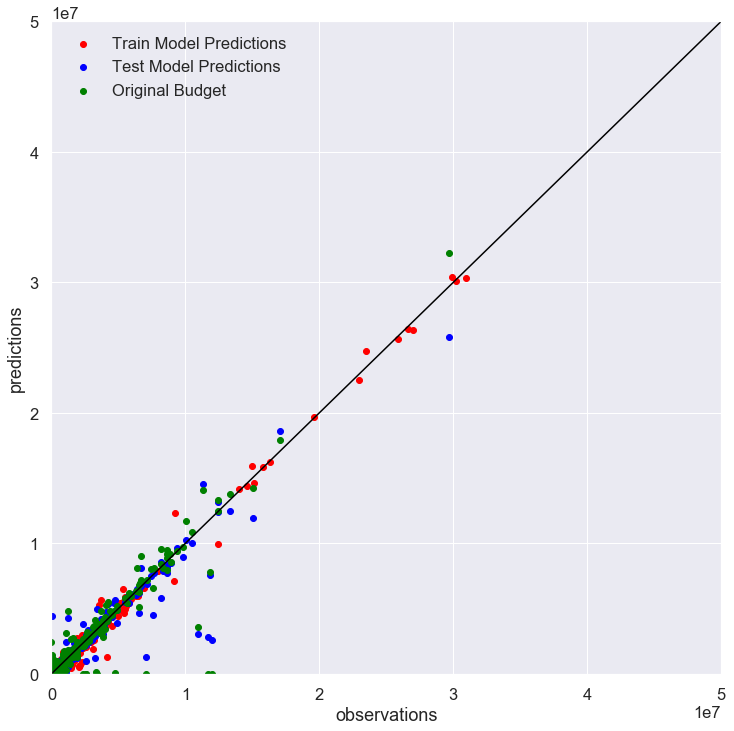

In [30]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

x = np.linspace(-100000000,100000000,10000)
plt.figure(figsize=(12,12))
plt.scatter(list(y_train), list(xgb_train_predictions), c='red',label="Train Model Predictions") #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue', label="Test Model Predictions") #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green', label="Original Budget") #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,50000000])
plt.ylim([-5,50000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title("")
plt.legend()


#fig.tight_layout()

Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals')

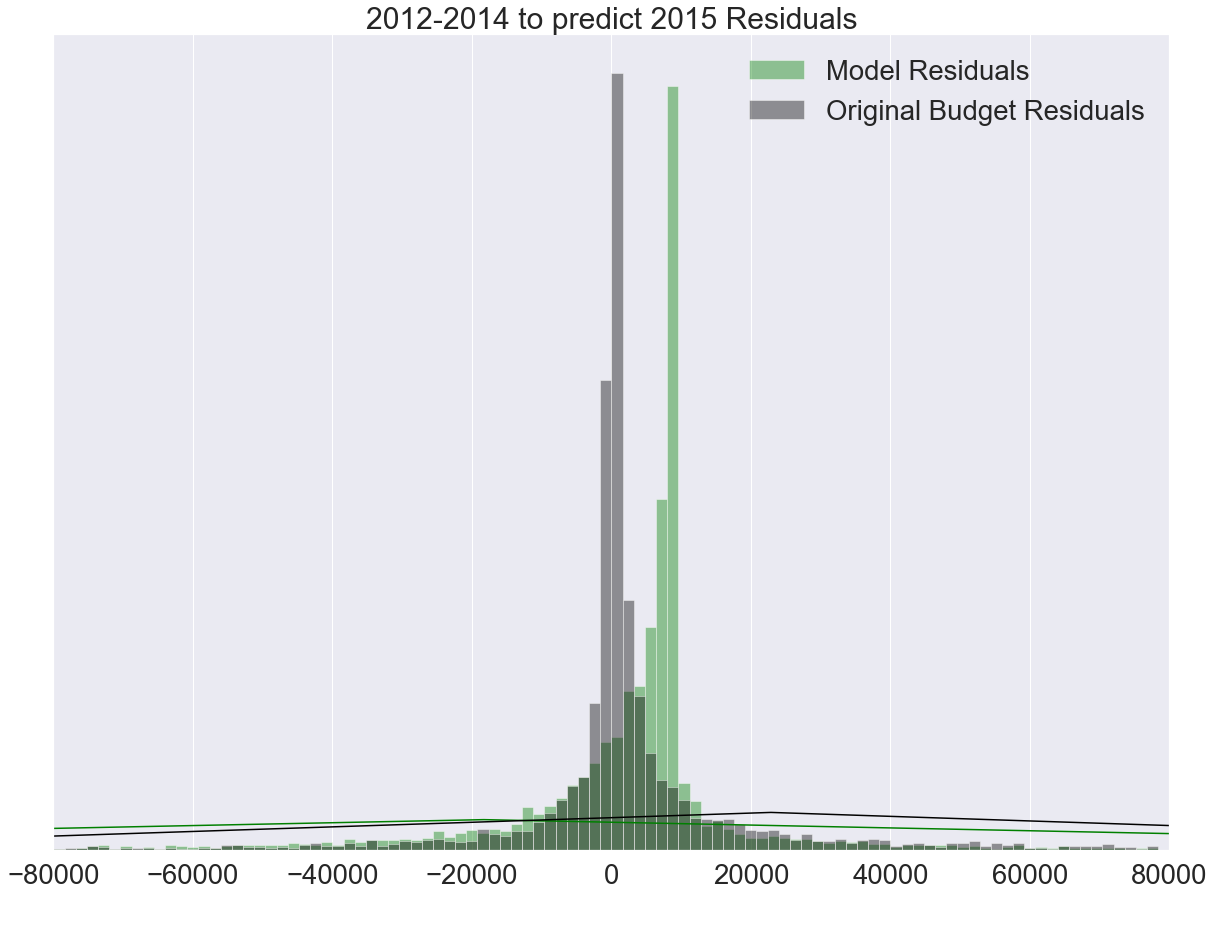

In [31]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals")

In [32]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
yt = mr = pd.DataFrame(pd.Series(y_test))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
yt = pd.DataFrame(yt[0].values)
ob_greater_80K = ob.loc[(ob[0]>80000) | (ob[0]<-80000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>80000) | (mr[0]<-80000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]
yt_greater_80K = yt.loc[(yt[0]>80000) | (yt[0]<-80000)][0]



In [33]:
abs(ob_greater_80K)[:10]

52     874751.013317
96     158358.755458
108    173960.501496
120    153429.655782
150    207365.833478
151     90773.501230
156    488409.429742
204     93567.031256
226    128664.076630
254     92642.525713
Name: 0, dtype: float64

In [34]:
abs(mr_greater_80K[:10])

0     2.170118e+05
2     3.447005e+05
6     4.045913e+05
17    1.339825e+05
31    7.321399e+05
34    1.739676e+05
45    1.063926e+05
47    1.188677e+05
49    3.955722e+06
52    8.640754e+06
Name: 0, dtype: float64

Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals Over 80K')

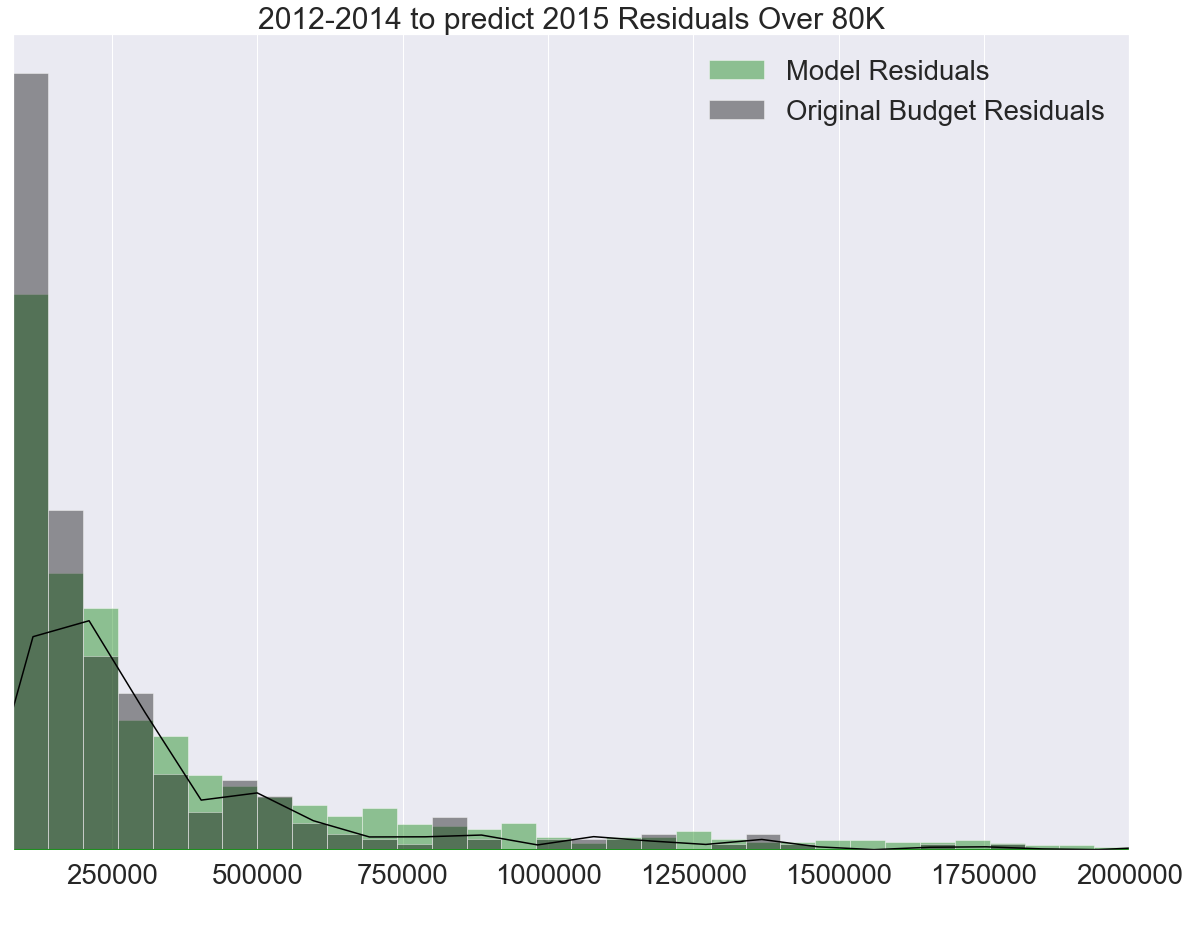

In [35]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(80000,3000000,3000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(80000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 80K")

In [36]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>200000) | (ob[0]<-200000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>200000) | (mr[0]<-200000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]


Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals Over 200K')

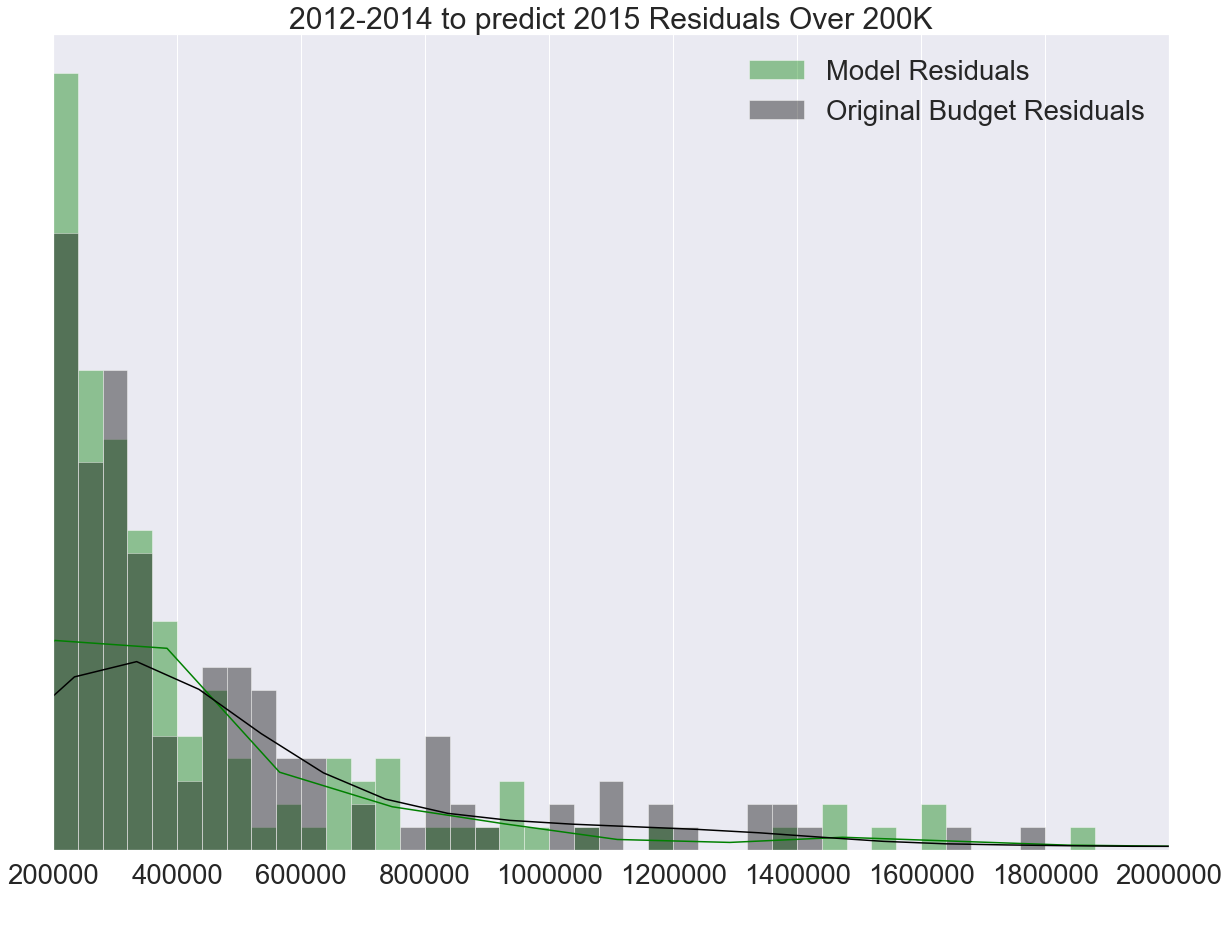

In [37]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(200000,2000000,2000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(200000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 200K")

In [38]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>2000000) | (ob[0]<-2000000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>2000000) | (mr[0]<-2000000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]

Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals Over 2M')

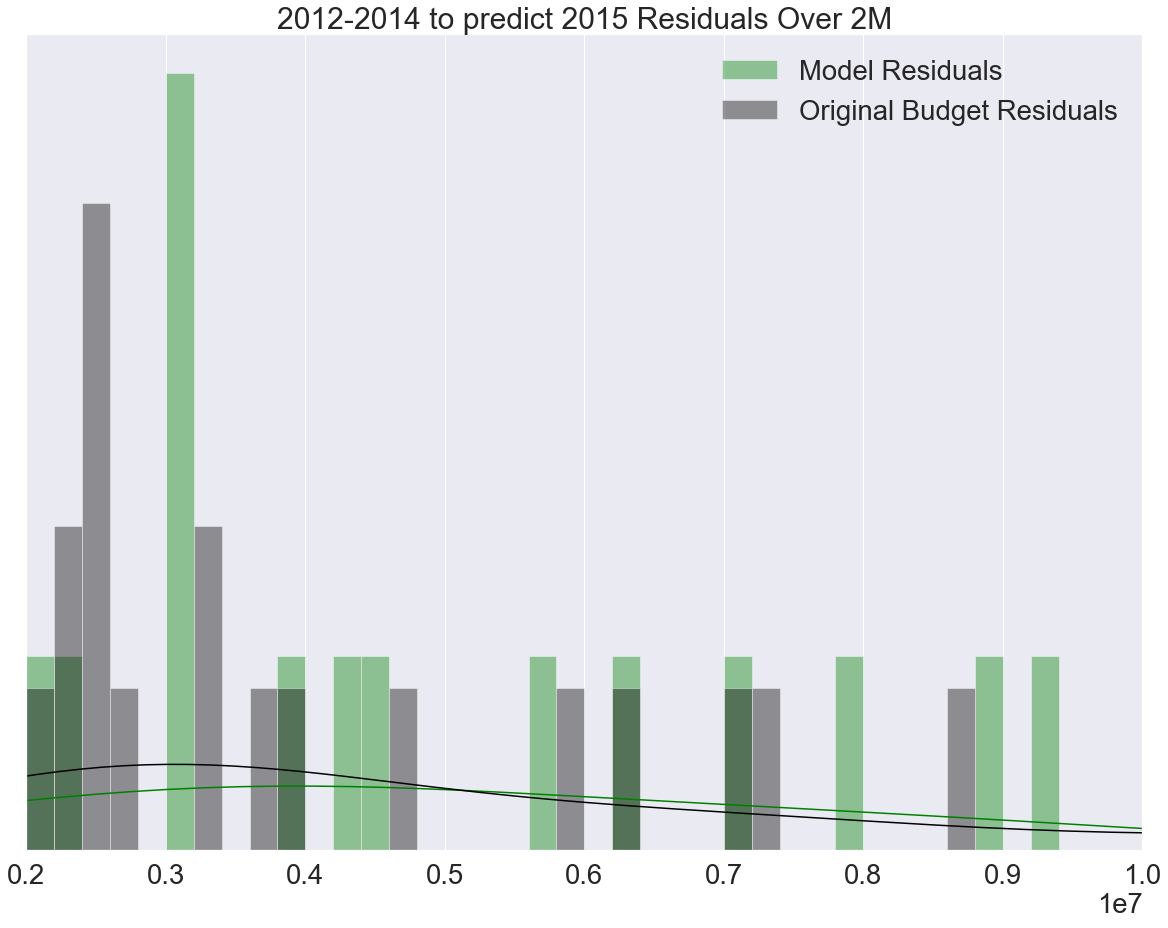

In [39]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 2M")

# 2013-2015 to predict 2016

In [40]:
splits_to_try = [
    
                #predicting off "two years"
                 #[(0,1),(1,2),'10-11 to predict 11'],
                 #[(0,2),(2,3),'10-11 to predict 12'],
                 #[(0,3),(3,4),'10-12 to predict 13'],
                 #[(0,3),(3,5),'10-12 to predict 13 and 14'],
                 #[(2,4),(4,5),'12-13 to predict 14'],
                 #[(1,4),(4,5),'11-13 to predict 14'], 
                 #[(1,4),(4,6),'11-13 to predict 14 and 15'],
                 #[(3,5),(5,6),'13-14 to predict 15'],
                 #[(2,5),(5,6),'12-14 to predict 15'],
                 #[(2,5),(5,7),'12-14 to predict 15 and 16'],
                 #[(4,6),(6,7),'14-15 to predict 16'],
                 [(3,6),(6,7),'13-15 to predict 16'], 
    
                #predicting off "three" years
    
                 #[(0,4),(5,6),'10-13 to predict 14'],
                 #[(0,4),(4,6),'10-13 to predict 14 and 15'],
                 #[(0,4),(4,7),'10-13 to predict 14 and 15 and 16'],
                 #[(1,5),(5,6),'11-14 to predict 15'],
                 #[(1,5),(5,7),'11-14 to predict 15 and 16'],
                 #[(2,6),(6,7),'12-15 to predict 16']
                ]

In [41]:
hold_list = []
weight_df_list = []
for split in splits_to_try:
    
    hold_dict = {}
    
    X_train = pd.concat([x for x in fy_list[split[0][0]:split[0][1]]])
    y_train = X_train['Actuals']
    X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)
    X_test = pd.concat([x for x in fy_list[split[1][0]:split[1][1]]])
    y_test = X_test['Actuals']
    y_original_budget = X_test['Original Budget']
    X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

    model = xgb.XGBRegressor(subsample= 0.8, min_child_weight= 1, max_depth= 4, gamma= 1, seed=1001, colsample_bytree= 1.0)
    model.fit(X_train,y_train)

    xgb_test_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)

    model_test_RMSE = np.sqrt(np.mean((xgb_test_predictions-y_test)**2))
    model_train_RMSE = np.sqrt(np.mean((xgb_train_predictions-y_train)**2))
    original_budget_RMSE = np.sqrt(np.mean((y_original_budget-y_test)**2))
    
    weight_dict = model.get_booster().get_score(importance_type="weight")
    weight_df = pd.DataFrame(weight_dict, index=range(len(weight_dict)))
    weight_df = weight_df.T[0].sort_values(ascending=False)
    
    weight_df_list.append(weight_df)

    hold_dict.update({'split': split[2]})
    hold_dict.update({'model_test_RMSE': model_test_RMSE})
    hold_dict.update({'model_train_RMSE': model_train_RMSE})
    hold_dict.update({'original_budget_RMSE': original_budget_RMSE})
    hold_dict.update({'test_predictions': xgb_test_predictions})
    hold_dict.update({'train_predictions' : xgb_train_predictions})
    hold_dict.update({'y_test' : y_test})
    hold_dict.update({'y_train' : y_train})
    hold_dict.update({'original_budget' : y_original_budget})
    hold_list.append(hold_dict)
    
   
results_df = pd.DataFrame(hold_list)
results_df['Model Improvement'] = results_df['original_budget_RMSE']-results_df['model_test_RMSE']
results_df



[14:20:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,model_test_RMSE,model_train_RMSE,original_budget,original_budget_RMSE,split,test_predictions,train_predictions,y_test,y_train,Model Improvement
0,515683.511769,126114.645978,0 306531.0 1 0.0 2 ...,503342.504512,13-15 to predict 16,"[238182.3, 13608.875, 8456.023, 95786.46, 3898...","[148648.28, 55633.09, 8456.023, 115151.48, 389...",0 2.670169e+05 1 0.000000e+00 2 ...,0 1.535889e+05 1 0.000000e+00 2 ...,-12341.007257


In [42]:
weight_df

Original Budget                                     247
1Y_Past_OA_Difference                                72
1Y_Past_Actuals                                      65
Unnamed: 0                                           59
3Y_Past_OA_Difference                                57
3Y_Past_Actuals                                      47
2Y_Past_OA_Difference                                36
2Y_1Y_OA_Difference_Mean                             33
2Y_1Y_Actuals_Mean                                   21
2Y_Past_Actuals                                      19
3Y_Past_Original_Budget                              19
1Y_Past_Original_Budget                              16
GL Account                                           15
Fund Id                                              15
City Council District A_B Stardig                    13
Over_Budget_Prediction                               10
Business Area                                         9
Controller_C Brown                              

In [43]:

y_train = downsample(y_train.values, int(len(y_train.values)/5))
y_test = downsample(y_test.values, int(len(y_test)/2))
xgb_test_predictions = downsample(xgb_test_predictions, int(len(xgb_test_predictions)/2))
xgb_train_predictions = downsample(xgb_train_predictions, int(len(xgb_train_predictions)/5))
y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))
# split = results_df.iloc[0]['split']



In [44]:
original_budget_residuals = y_original_budget-y_test
model_residuals = xgb_test_predictions-y_test

In [45]:
model_residuals_series = pd.Series(model_residuals)
original_budget_residuals_series =pd.Series(original_budget_residuals)

In [56]:
sum(abs(xgb_test_predictions-y_test))

255097533.55237982

In [57]:
sum(abs(y_original_budget-y_test))

222911266.05975938

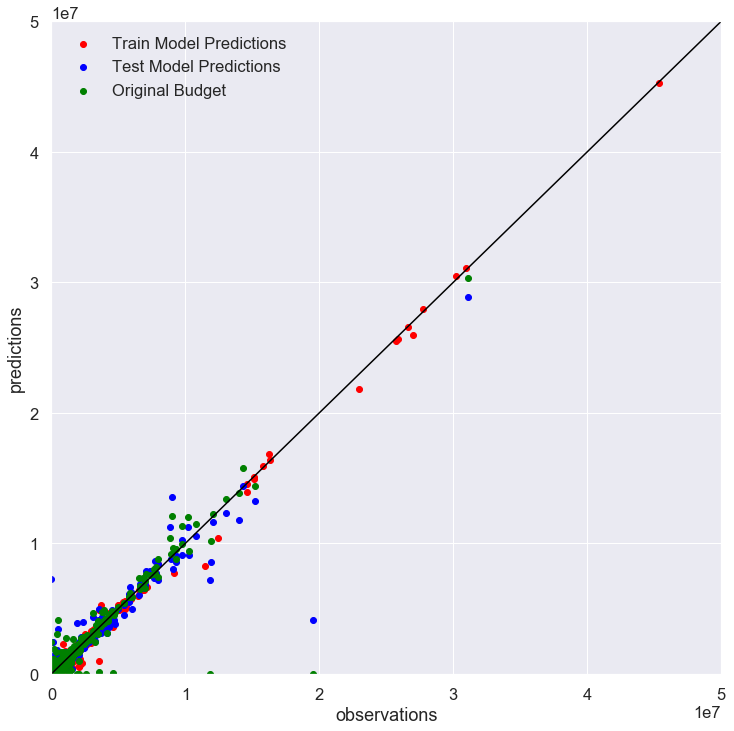

In [46]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

x = np.linspace(-100000000,100000000,10000)
plt.figure(figsize=(12,12))
plt.scatter(list(y_train), list(xgb_train_predictions), c='red',label="Train Model Predictions") #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue', label="Test Model Predictions") #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green', label="Original Budget") #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,50000000])
plt.ylim([-5,50000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title("")
plt.legend()


#fig.tight_layout()

Text(0.5, 1.0, '2013-2015 to predict 2016 Residuals')

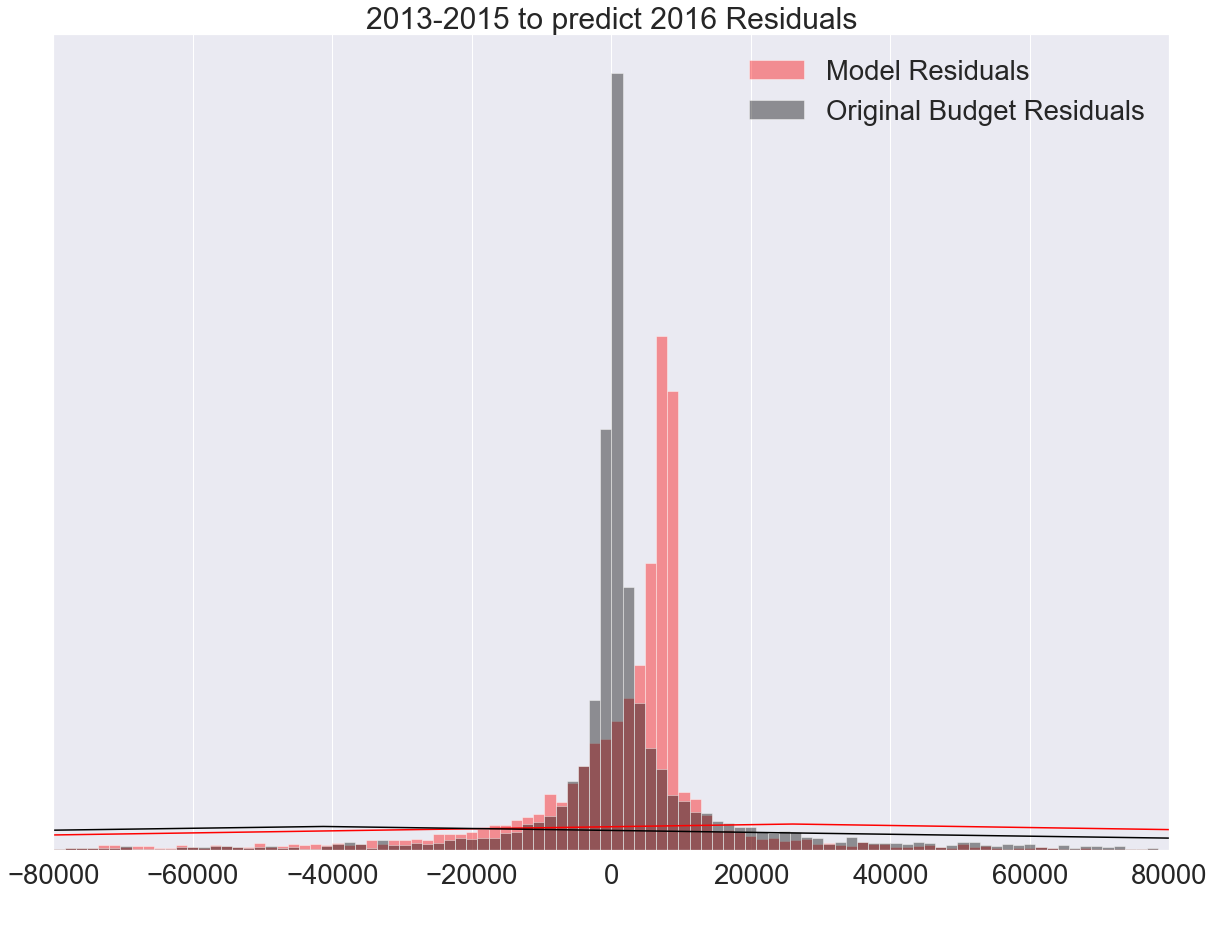

In [47]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals")


In [48]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
yt = mr = pd.DataFrame(pd.Series(y_test))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
yt = pd.DataFrame(yt[0].values)
ob_greater_80K = ob.loc[(ob[0]>80000) | (ob[0]<-80000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>80000) | (mr[0]<-80000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]
yt_greater_80K = yt.loc[(yt[0]>80000) | (yt[0]<-80000)][0]



Text(0.5, 1.0, '2013-2015 to predict 2016 Residuals Over 80K')

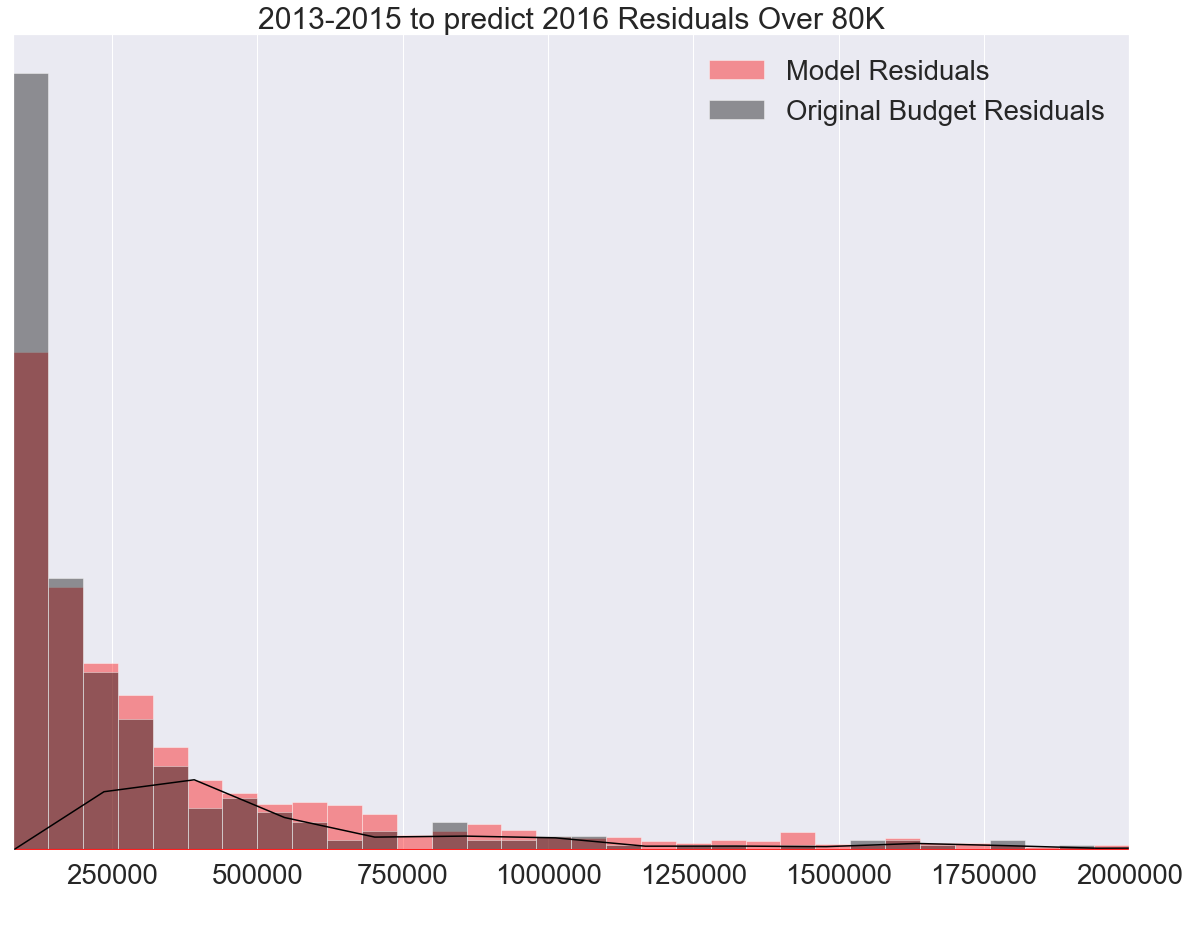

In [49]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(80000,3000000,3000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(80000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 80K")

In [50]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>200000) | (ob[0]<-200000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>200000) | (mr[0]<-200000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]


Text(0.5, 1.0, '2012-2014 to predict 2015 Residuals Over 200K')

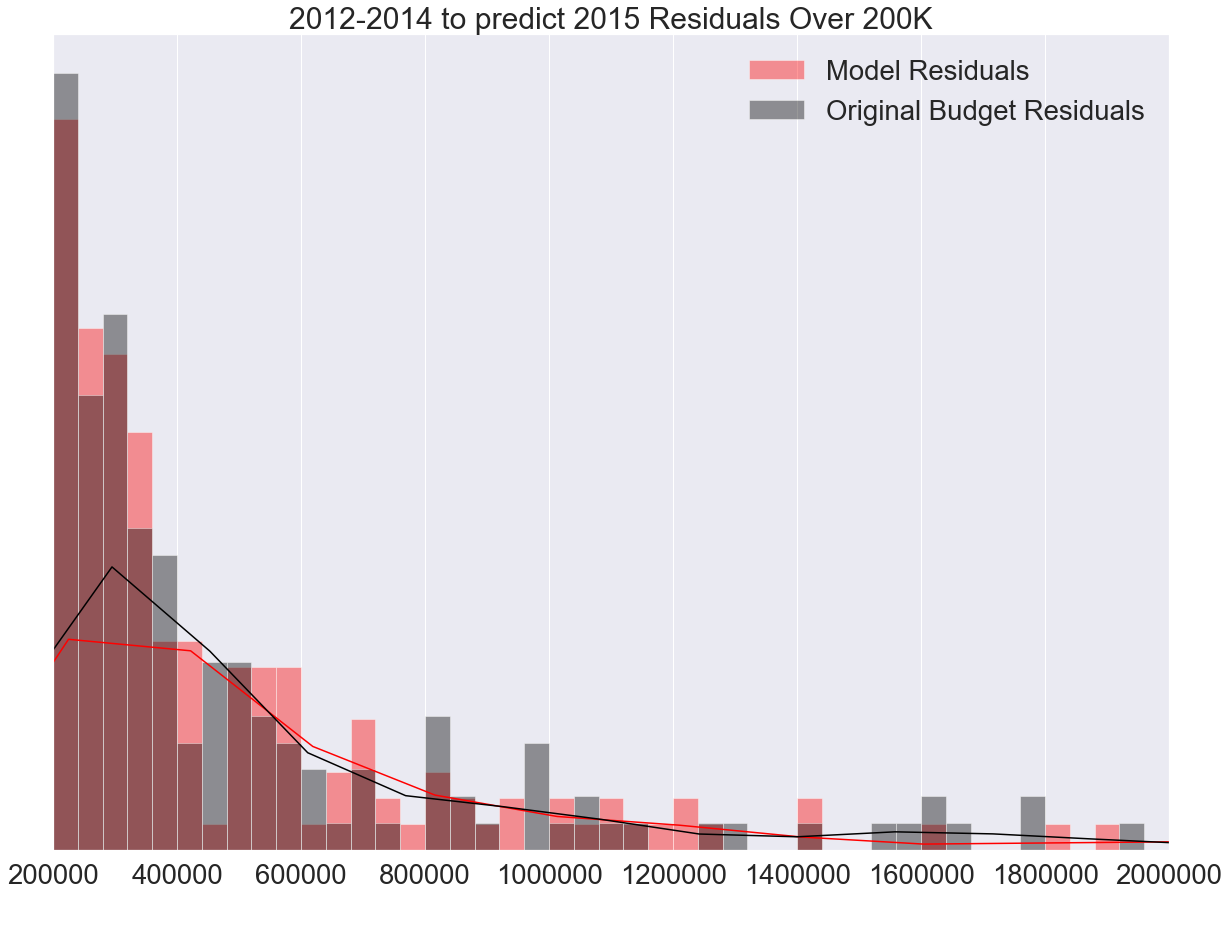

In [52]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(200000,2000000,2000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(200000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 200K")

In [53]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>2000000) | (ob[0]<-2000000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>2000000) | (mr[0]<-2000000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]

Text(0.5, 1.0, '2013-2015 to predict 2016 Residuals Over 2M')

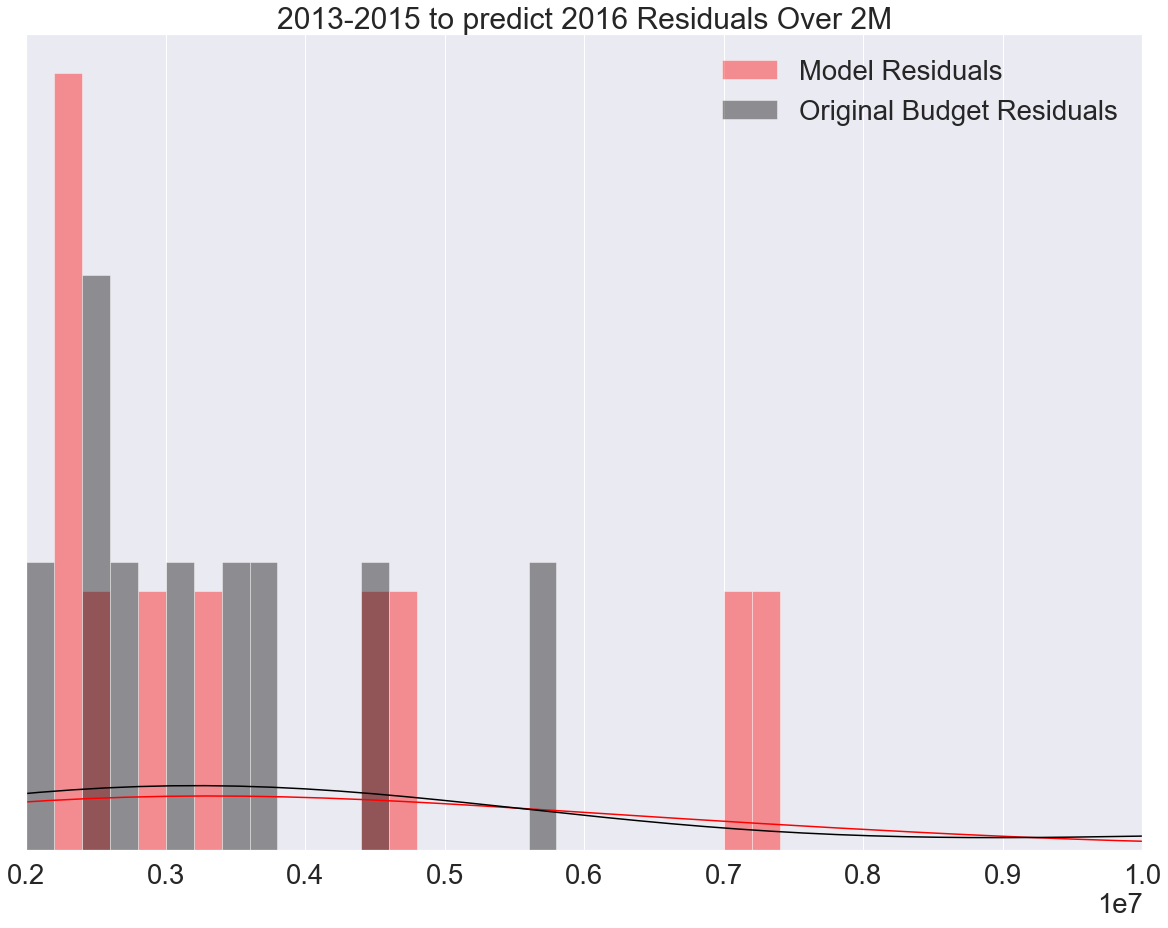

In [54]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 2M")

In [ ]:
from scipy.interpolate import interp1d

def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

#https://stackoverflow.com/questions/53307107/how-do-i-downsample-a-1d-numpy-array

# H2o

In [71]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: Picked up _JAVA_OPTIONS: -Xverify:none; java version "12.0.1" 2019-04-16; Java(TM) SE Runtime Environment (build 12.0.1+12); Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/0y/vcjmh6651517f16c4qtnxyg00000gq/T/tmp11hfx9xd
  JVM stdout: /var/folders/0y/vcjmh6651517f16c4qtnxyg00000gq/T/tmp11hfx9xd/h2o_josephdown_started_from_python.out
  JVM stderr: /var/folders/0y/vcjmh6651517f16c4qtnxyg00000gq/T/tmp11hfx9xd/h2o_josephdown_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.2
H2O cluster version age:,1 month and 16 days
H2O cluster name:,H2O_from_python_josephdown_rx1gzk
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [72]:
fy_10 = pd.read_csv('2010_clfpred')
fy_11 = pd.read_csv('2011_clfpred')
fy_12 = pd.read_csv('2012_clfpred')
fy_13 = pd.read_csv('2013_clfpred')
fy_14 = pd.read_csv('2014_clfpred')
fy_15 = pd.read_csv('2015_clfpred')
fy_16 = pd.read_csv('2016_clfpred')

fy_list = [fy_10, fy_11, fy_12, fy_13, fy_14, fy_15, fy_16]

del fy_10
del fy_11
del fy_12
del fy_13
del fy_14
del fy_15
del fy_16
gc.collect()


104

In [163]:
# fy_list[5]['Actuals'] = pd.read_csv('2015_clfpred')['Actuals']
# y_original_budget = pd.read_csv('2015_clfpred')['Original Budget']

In [73]:
X_train = pd.concat([x for x in fy_list[3:5]])
y_train = X_train['Actuals']
X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

X_test = fy_list[5]
y_test = fy_list[5]['Actuals']
y_original_budget = X_test['Original Budget']
X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)



In [74]:
# create h2o frame for training data
training_frame = pd.concat([X_train,y_train], axis=1)
training_frame.columns = list(training_frame.columns[:-1]) + ['Actuals']
training_frame = h2o.H2OFrame(training_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [75]:
# create h2o frame for testing data
testing_frame = pd.concat([X_test,y_test], axis=1)
testing_frame.columns = list(testing_frame.columns[:-1]) + ['Actuals']
testing_frame = h2o.H2OFrame(testing_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [76]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(None, 'Actuals', training_frame)

AutoML progress: |████████████████████████████████████████████████████████| 100%


### Model RMSE

In [77]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((predicted_actuals['predict'].as_data_frame()['predict'].values-y_test)**2))

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


435558.46073281195


### Budget RMSE

In [78]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((y_original_budget-y_test)**2))

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


511970.9490099012

In [79]:
train_predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_train, y_train], axis=1)))

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [80]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190912_145301_model_2

Model Summary: 


,number_of_trees
,162.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 176311578.50883707
RMSE: 13278.237025630966
MAE: 5230.081385183881
RMSLE: NaN
Mean Residual Deviance: 176311578.50883707

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 144333817567.32318
RMSE: 379912.9078714267
MAE: 36443.64070400303
RMSLE: NaN
Mean Residual Deviance: 144333817567.32318
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,36443.68,3382.9658,33609.098,40438.58,34420.61,43431.938,30318.164
mean_residual_deviance,144333718000.0000000,71891943000.0000000,61152604000.0000000,291350479000.0000000,82828632000.0000000,241570398000.0000000,44766458000.0000000
mse,144333718000.0000000,71891943000.0000000,61152604000.0000000,291350479000.0000000,82828632000.0000000,241570398000.0000000,44766458000.0000000
r2,0.9916248,0.0069891,0.9979792,0.9957427,0.9976841,0.9720061,0.9947116
residual_deviance,144333718000.0000000,71891943000.0000000,61152604000.0000000,291350479000.0000000,82828632000.0000000,241570398000.0000000,44766458000.0000000
rmse,355587.62,94581.09,247290.53,539768.94,287799.66,491498.12,211580.86
rmsle,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2019-09-12 15:17:02,4 min 50.231 sec,0.0,5513532.9853910,286103.4115569,30399045980994.6640625
,2019-09-12 15:17:05,4 min 52.790 sec,5.0,4271795.5558740,222523.6353532,18248237271184.8046875
,2019-09-12 15:17:06,4 min 54.248 sec,10.0,3284267.6375752,172684.7107698,10786413915223.7070312
,2019-09-12 15:17:08,4 min 55.768 sec,15.0,2525077.9968529,133978.2640711,6376018890190.4628906
,2019-09-12 15:17:09,4 min 57.305 sec,20.0,1981337.6592750,104928.2972811,3925698920061.2768555
---,---,---,---,---,---,---
,2019-09-12 15:17:54,5 min 42.032 sec,145.0,16689.7351134,5441.8202944,278547258.1545772
,2019-09-12 15:17:56,5 min 44.017 sec,150.0,15119.9916040,5372.9485979,228614146.1052730
,2019-09-12 15:17:58,5 min 46.066 sec,155.0,14471.0829484,5310.1651687,209412241.7008993
,2019-09-12 15:18:00,5 min 48.093 sec,160.0,13539.5074355,5253.0844963,183318261.5965647



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
OriginalBudget,2142781449084862464.0000000,1.0,0.4356949
1Y_Past_Actuals,1107015863355047936.0000000,0.5166257,0.2250911
3Y_Past_Actuals,657535097603358720.0000000,0.3068606,0.1336976
2Y_Past_Actuals,400381730415968256.0000000,0.1868514,0.0814102
3Y_Past_Original_Budget,137651597302824960.0000000,0.0642397,0.0279889
---,---,---,---
BusinessAreaName_CityCouncil,7805998080.0000000,0.0000000,0.0000000
FundName_CableTelevisionFund,6532218880.0000000,0.0000000,0.0000000
FundName_DigitalHoustonSpecialRevenue,820163520.0000000,0.0000000,0.0000000
FundName_SupplementalEnvironmentalProj,533469024.0000000,0.0000000,0.0000000



See the whole table with table.as_data_frame()


In [84]:
y_train = downsample(y_train.values, int(len(y_train.values)/5))
y_test = downsample(y_test.values, int(len(y_test)/2))
predicted_actuals = downsample(predicted_actuals, int(len(predicted_actuals)/2))
train_predicted_actuls = downsample(train_predicted_actuls, int(len(train_predicted_actuls)/5))
y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))


In [ ]:
### Being a bad coder here and or lazy

In [ ]:
xgb_test_predictions = predicted_actuals
xgb_train_predictions = train_predicted_actuals

In [ ]:
original_budget_residuals = y_original_budget-y_test
model_residuals = xgb_test_predictions-y_test

In [ ]:
model_residuals_series = pd.Series(model_residuals)
original_budget_residuals_series =pd.Series(original_budget_residuals)

# Plotting H2O 2015

In [ ]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

x = np.linspace(-100000000,100000000,10000)
plt.figure(figsize=(12,12))
plt.scatter(list(y_train), list(xgb_train_predictions), c='red',label="Train Model Predictions") #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue', label="Test Model Predictions") #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green', label="Original Budget") #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,50000000])
plt.ylim([-5,50000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title("")
plt.legend()


#fig.tight_layout()

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals")


In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
yt = mr = pd.DataFrame(pd.Series(y_test))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
yt = pd.DataFrame(yt[0].values)
ob_greater_80K = ob.loc[(ob[0]>80000) | (ob[0]<-80000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>80000) | (mr[0]<-80000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]
yt_greater_80K = yt.loc[(yt[0]>80000) | (yt[0]<-80000)][0]



In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(80000,3000000,3000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(80000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 80K")

In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>200000) | (ob[0]<-200000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>200000) | (mr[0]<-200000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]


In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(200000,2000000,2000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(200000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 200K")

In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>2000000) | (ob[0]<-2000000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>2000000) | (mr[0]<-2000000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2012-2014 to predict 2015 Residuals Over 2M")

# H20 Predicting 2016

In [ ]:
X_train = pd.concat([x for x in fy_list[4:6]])
y_train = X_train['Actuals']
X_train.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)

X_test = fy_list[6]
y_test = X_test['Actuals']
y_original_budget = X_test['Original Budget']
X_test.drop(['OA_Difference','Actuals','Over Budget','Current Budget'] + drop_list, axis=1, inplace=True)



In [ ]:
# create h2o frame for training data
training_frame = pd.concat([X_train,y_train], axis=1)
training_frame.columns = list(training_frame.columns[:-1]) + ['Actuals']
training_frame = h2o.H2OFrame(training_frame)

In [ ]:
# create h2o frame for testing data
testing_frame = pd.concat([X_test,y_test], axis=1)
testing_frame.columns = list(testing_frame.columns[:-1]) + ['Actuals']
testing_frame = h2o.H2OFrame(testing_frame)

In [ ]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(None, 'Actuals', training_frame)

### Model RMSE

In [ ]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((predicted_actuals['predict'].as_data_frame()['predict'].values-y_test)**2))


### Budget RMSE

In [ ]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((y_original_budget-y_test)**2))

In [ ]:
train_predicted_actuls = aml.predict(h2o.H2OFrame(pd.concat([X_train, y_train], axis=1)))

In [ ]:
aml.leader

In [ ]:
y_train = downsample(y_train.values, int(len(y_train.values)/5))
y_test = downsample(y_test.values, int(len(y_test)/2))
predicted_actuals = downsample(predicted_actuals, int(len(predicted_actuals)/2))
train_predicted_actuls = downsample(train_predicted_actuls, int(len(train_predicted_actuls)/5))
y_original_budget = downsample(y_original_budget.values, int(len(y_original_budget.values)/2))


In [ ]:
### Being a bad coder here and or lazy

In [ ]:
xgb_test_predictions = predicted_actuals
xgb_train_predictions = train_predicted_actuals

In [ ]:
original_budget_residuals = y_original_budget-y_test
model_residuals = xgb_test_predictions-y_test

In [ ]:
model_residuals_series = pd.Series(model_residuals)
original_budget_residuals_series =pd.Series(original_budget_residuals)

# Plotting H2O 2016

In [ ]:
# fig, ax = plt.subplots(nrows=2,ncols=3)
# fig.set_size_inches(16,12)
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

x = np.linspace(-100000000,100000000,10000)
plt.figure(figsize=(12,12))
plt.scatter(list(y_train), list(xgb_train_predictions), c='red',label="Train Model Predictions") #alpha=.95)
plt.scatter(y_test, xgb_test_predictions, c='blue', label="Test Model Predictions") #alpha=.95)
plt.scatter(y_test, y_original_budget, c='green', label="Original Budget") #alpha=.95)
plt.plot(x,x,c='black')
plt.xlim([-5,50000000])
plt.ylim([-5,50000000])
plt.xlabel('observations')
plt.ylabel('predictions')
plt.title("")
plt.legend()


#fig.tight_layout()

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(-80000,80000,80000/50)

sns.distplot(model_residuals, label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(original_budget_residuals, label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(-80000,80000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals")


In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
yt = mr = pd.DataFrame(pd.Series(y_test))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
yt = pd.DataFrame(yt[0].values)
ob_greater_80K = ob.loc[(ob[0]>80000) | (ob[0]<-80000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>80000) | (mr[0]<-80000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]
yt_greater_80K = yt.loc[(yt[0]>80000) | (yt[0]<-80000)][0]



In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(80000,3000000,3000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(80000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 80K")

In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>200000) | (ob[0]<-200000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>200000) | (mr[0]<-200000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]


In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(200000,2000000,2000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='red',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(200000,2000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 200K")

In [ ]:
ob = pd.DataFrame(pd.Series(original_budget_residuals))
mr = pd.DataFrame(pd.Series(model_residuals))
mr = pd.DataFrame(mr[0].values)
ob = pd.DataFrame(ob[0].values)
ob_greater_80K = ob.loc[(ob[0]>2000000) | (ob[0]<-2000000)][0]
#ob_less_neg_80K = ob.loc[(ob[0]<80000)][0]
mr_greater_80K = mr.loc[(mr[0]>2000000) | (mr[0]<-2000000)][0]
#mr_less_neg_80K = mr.loc[(ob[0]<-80000)][0]

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
 
fig, ax = plt.subplots(figsize=(20,15))
bins_ = np.arange(2000000,10000000,10000000/50)

sns.distplot(abs(mr_greater_80K), label='Model Residuals', norm_hist=True, bins = bins_, color='green',   ax = ax)
sns.distplot(abs(ob_greater_80K), label='Original Budget Residuals',bins=bins_, color='black',  ax = ax)
    
ax.set_title(" ")
ax.set_ylabel(" ")
ax.set_xlabel(" ")
ax.set_xlim(2000000,10000000)
ax.legend()
ax.get_yaxis().set_visible(False)
ax.set_title("2013-2015 to predict 2016 Residuals Over 2M")